# Movie Recommendation System

## Data EDA & Preprocessing

### 1. Install Required Packages

In [32]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


### 2. Import libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import nest_asyncio
nest_asyncio.apply()
from sentence_transformers import SentenceTransformer
from collections import Counter
import re
from rapidfuzz import process, fuzz
import torch
import faiss

load_dotenv()

True

### 3. EDA

In [34]:
df = pd.read_csv('data/raw/Movies_Dataset.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,2000,102 Dalmatians,American,Kevin Lima,"Glenn Close, Gérard Depardieu, Alice Evans","comedy, family",https://en.wikipedia.org/wiki/102_Dalmatians,"After three years in prison, Cruella de Vil ha..."
1,2000,28 Days,American,Betty Thomas,"Sandra Bullock, Viggo Mortensen",drama,https://en.wikipedia.org/wiki/28_Days_(film),Gwen Cummings (Sandra Bullock) spends her nigh...
2,2000,3 Strikes,American,DJ Pooh,"Brian Hooks, N'Bushe Wright",comedy,https://en.wikipedia.org/wiki/3_Strikes_(film),Robert Douglas (Brian Hooks) is in prison for ...
3,2000,The 6th Day,American,Roger Spottiswoode,"Arnold Schwarzenegger, Robert Duvall",science fiction,https://en.wikipedia.org/wiki/The_6th_Day,At some point in the indeterminate near future...
4,2000,The Adventures of Rocky and Bullwinkle,American,Des McAnuff,"Rene Russo, Jason Alexander, Robert De Niro, P...",comedy,https://en.wikipedia.org/wiki/The_Adventures_o...,35 years since their show's cancellation in 19...


In [35]:
print("Shape of dataset:", df.shape)
print("\nColumn names:\n", df.columns.tolist())
df.info()

Shape of dataset: (12560, 8)

Column names:
 ['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12560 entries, 0 to 12559
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      12560 non-null  int64 
 1   Title             12560 non-null  object
 2   Origin/Ethnicity  12560 non-null  object
 3   Director          12560 non-null  object
 4   Cast              12042 non-null  object
 5   Genre             12560 non-null  object
 6   Wiki Page         12560 non-null  object
 7   Plot              12560 non-null  object
dtypes: int64(1), object(7)
memory usage: 785.1+ KB


In [36]:
print("\nMissing values per column:\n", df.isnull().sum())
print("\nNumber of duplicated rows:", df.duplicated().sum())


Missing values per column:
 Release Year          0
Title                 0
Origin/Ethnicity      0
Director              0
Cast                518
Genre                 0
Wiki Page             0
Plot                  0
dtype: int64

Number of duplicated rows: 0


### 4. Data Preprocessing

In [37]:
df['Genre'] = df['Genre'].replace("unknown", pd.NA)
df['Director'] = df['Director'].replace("Unknown", pd.NA)
df['Director'] = df['Director'].fillna("unknown_director")
df['Cast'] = df['Cast'].fillna("unknown_cast")

#### Handle Missing Genres

In [38]:
model = SentenceTransformer('all-MiniLM-L6-v2')

known_df = df[df['Genre'].notna() & (df['Genre'].str.strip() != '')]
missing_df = df[df['Genre'].isna() | (df['Genre'].str.strip() == '')]

known_embeddings = model.encode(known_df['Plot'].tolist(), batch_size=64, show_progress_bar=True)
missing_embeddings = model.encode(missing_df['Plot'].tolist(), batch_size=64, show_progress_bar=True)

knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(known_embeddings)

distances, indices = knn.kneighbors(missing_embeddings)

predicted_genres = []
for i, neighbors in enumerate(indices):
    neighbor_genres = known_df.iloc[neighbors]['Genre']
    counts = Counter(neighbor_genres)

    selected = [g for g, c in counts.items() if c >= 2]

    if not selected:
        selected = [g for g, _ in counts.most_common(2)]

    predicted_genres.append(", ".join(selected))

df.loc[missing_df.index, 'Genre'] = predicted_genres

print(df[['Title', 'Genre']].head(20))
print("Still missing:", df['Genre'].isna().sum())


Batches: 100%|██████████| 38/38 [00:03<00:00, 10.85it/s]


                                     Title             Genre
0                           102 Dalmatians    comedy, family
1                                  28 Days             drama
2                                3 Strikes            comedy
3                              The 6th Day   science fiction
4   The Adventures of Rocky and Bullwinkle            comedy
5                    All the Pretty Horses           western
6                            Almost Famous     comedy, drama
7                          American Psycho  comedy, thriller
8                           Animal Factory       crime drama
9                           The Art of War            action
10                      Autumn in New York           romance
11                                    Bait            action
12                              Bamboozled            satire
13                       Battlefield Earth   science fiction
14                               The Beach         adventure
15                      

#### Generate Keywords for Movies

In [39]:
tfidf = TfidfVectorizer(
    max_features=10000,      
    stop_words='english'
)

tfidf_matrix = tfidf.fit_transform(df['Plot'].fillna(""))
feature_names = tfidf.get_feature_names_out()

def extract_keywords_from_index(index, top_n=30):
    row = tfidf_matrix[index].toarray().flatten()
    top_indices = row.argsort()[-top_n:][::-1]
    return [feature_names[i] for i in top_indices]

df['Keywords'] = [extract_keywords_from_index(i, top_n=30) for i in range(len(df))]

print(df[['Title', 'Keywords']].head())

                                    Title  \
0                          102 Dalmatians   
1                                 28 Days   
2                               3 Strikes   
3                             The 6th Day   
4  The Adventures of Rocky and Bullwinkle   

                                            Keywords  
0  [puppies, chloe, kevin, alonzo, fortune, dog, ...  
1  [gwen, jasper, eddie, addict, rehab, andrea, l...  
2  [robert, tone, mike, jenkins, prison, tape, bl...  
3  [adam, clone, talia, hank, tripp, marshall, ag...  
4  [rocky, boris, karen, fearless, natasha, leade...  



Movies per binned year group:

Year Binned
2000s    2508
2005s    3358
2010s    4507
2015s    2187
Name: count, dtype: int64


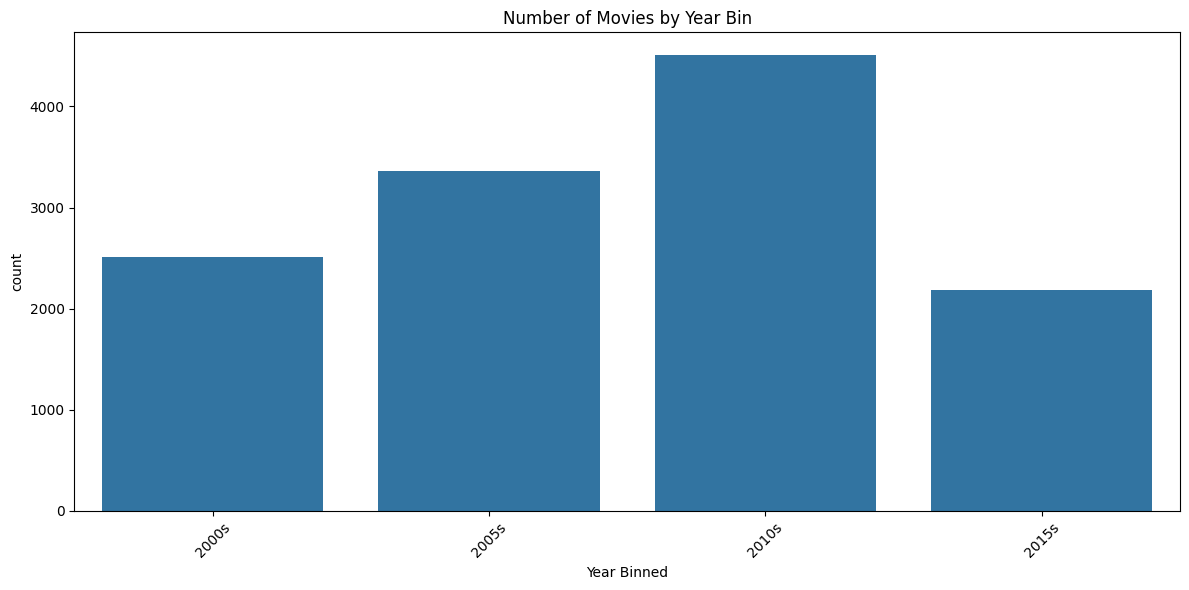

In [40]:
bins = list(range(2000, 2021, 5)) 
labels = [f"{b}s" for b in bins[:-1]]  

df['Year Binned'] = pd.cut(df['Release Year'], bins=bins, labels=labels, right=False)

print("\nMovies per binned year group:\n")
print(df['Year Binned'].value_counts().sort_index())

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Year Binned', order=labels)
plt.title("Number of Movies by Year Bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
df = df.drop(columns=[
                        'Wiki Page'
                        ])
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Plot,Keywords,Year Binned
0,2000,102 Dalmatians,American,Kevin Lima,"Glenn Close, Gérard Depardieu, Alice Evans","comedy, family","After three years in prison, Cruella de Vil ha...","[puppies, chloe, kevin, alonzo, fortune, dog, ...",2000s
1,2000,28 Days,American,Betty Thomas,"Sandra Bullock, Viggo Mortensen",drama,Gwen Cummings (Sandra Bullock) spends her nigh...,"[gwen, jasper, eddie, addict, rehab, andrea, l...",2000s
2,2000,3 Strikes,American,DJ Pooh,"Brian Hooks, N'Bushe Wright",comedy,Robert Douglas (Brian Hooks) is in prison for ...,"[robert, tone, mike, jenkins, prison, tape, bl...",2000s
3,2000,The 6th Day,American,Roger Spottiswoode,"Arnold Schwarzenegger, Robert Duvall",science fiction,At some point in the indeterminate near future...,"[adam, clone, talia, hank, tripp, marshall, ag...",2000s
4,2000,The Adventures of Rocky and Bullwinkle,American,Des McAnuff,"Rene Russo, Jason Alexander, Robert De Niro, P...",comedy,35 years since their show's cancellation in 19...,"[rocky, boris, karen, fearless, natasha, leade...",2000s


In [42]:
df.to_csv('data/processed/Movies_Preprocessed.csv', index=False)

### 5. Recommendation Function

In [43]:
df = pd.read_csv("data/processed/Movies_Preprocessed.csv")

df.head(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Plot,Keywords,Year Binned
0,2000,102 Dalmatians,American,Kevin Lima,"Glenn Close, Gérard Depardieu, Alice Evans","comedy, family","After three years in prison, Cruella de Vil ha...","['puppies', 'chloe', 'kevin', 'alonzo', 'fortu...",2000s
1,2000,28 Days,American,Betty Thomas,"Sandra Bullock, Viggo Mortensen",drama,Gwen Cummings (Sandra Bullock) spends her nigh...,"['gwen', 'jasper', 'eddie', 'addict', 'rehab',...",2000s
2,2000,3 Strikes,American,DJ Pooh,"Brian Hooks, N'Bushe Wright",comedy,Robert Douglas (Brian Hooks) is in prison for ...,"['robert', 'tone', 'mike', 'jenkins', 'prison'...",2000s
3,2000,The 6th Day,American,Roger Spottiswoode,"Arnold Schwarzenegger, Robert Duvall",science fiction,At some point in the indeterminate near future...,"['adam', 'clone', 'talia', 'hank', 'tripp', 'm...",2000s
4,2000,The Adventures of Rocky and Bullwinkle,American,Des McAnuff,"Rene Russo, Jason Alexander, Robert De Niro, P...",comedy,35 years since their show's cancellation in 19...,"['rocky', 'boris', 'karen', 'fearless', 'natas...",2000s


In [44]:
_FAISS_AVAILABLE = True

def _nz(x):
    return "" if pd.isna(x) else str(x)

def _canon(s):
    return re.sub(r"\s+", " ", _nz(s).lower()).strip()

def _maybe_int(x):
    try:
        return int(str(x))
    except:
        return None

def _row_to_search_text(row):
    title = _nz(row.get("Title", ""))
    director = _nz(row.get("Director", ""))
    cast = _nz(row.get("Cast", ""))
    genre = _nz(row.get("Genre", ""))
    keywords = _nz(row.get("Keywords", ""))
    origin = _nz(row.get("Origin/Ethnicity", ""))
    plot = _nz(row.get("Plot", ""))
    year_bin = _nz(row.get("Year Binned", ""))

    return (
        f"{title}. "
        f"Director: {director}. "
        f"Cast: {cast}. "
        f"Genres: {genre}. "
        f"Keywords: {keywords}. "
        f"Origin: {origin}. "
        f"Plot: {plot}. {plot}. "
        f"Year: {year_bin}. "
        f"{title}."
    ).strip()

def _cosine_scores(query_emb, corpus_emb):
    return np.dot(corpus_emb, query_emb)

def _ensure_keywords_series(kw_col):
    if kw_col.dtype == object:
        def parse_cell(x):
            if isinstance(x, list):
                return [str(k).lower().strip() for k in x if str(k).strip()]
            if pd.isna(x):
                return []
            s = str(x).strip()
            if not s:
                return []
            parts = re.split(r"[|,;/]", s)
            return [p.lower().strip() for p in parts if p.strip()]
        return kw_col.apply(parse_cell)
    else:
        return kw_col.apply(lambda x: [str(k).lower().strip() for k in (x or [])])

def _jaccard(a, b):
    if not a or not b:
        return 0.0
    sa, sb = set(a), set(b)
    inter = len(sa & sb)
    if inter == 0:
        return 0.0
    return inter / float(len(sa | sb))

class SemanticMovieRecommender:
    # SBERT + FAISS ANN + Keyword boosting + explanations.
    # Columns expected in df (best-effort if missing):
    #     - Title (required)
    #     - Plot, Director, Cast, Genre, Keywords, Origin/Ethnicity, Year, Year Binned (optional)

    _COLLECTION_WORDS = r"(collection|series|saga|universe|all movies|filmography|trilogy|anthology)"

    def __init__(
        self,
        df: pd.DataFrame,
        model_name: str = "all-mpnet-base-v2",
        use_faiss: bool = True,
        ann_candidates: int = 200,
        keyword_overlap_weight: float = 0.25,
        person_boost_weight: float = 0.25,
        genre_boost_weight: float = 0.08,
        like_title_boost_weight: float = 0.10,
        duplicate_plot_weight: float = 1.0,
        verbose: bool = True,
    ):
        if "Title" not in df.columns:
            raise ValueError("DataFrame must have a 'Title' column.")

        self.df = df.reset_index(drop=True).copy()
        self.verbose = verbose

        # Normalize / prepare fields
        self.df["Title"] = self.df["Title"].astype(str)
        self.df["search_text"] = self.df.apply(_row_to_search_text, axis=1)

        # Keywords column normalization (for boosting & explanations)
        if "Keywords" in self.df.columns:
            self.df["_kw_list"] = _ensure_keywords_series(self.df["Keywords"])
        else:
            self.df["_kw_list"] = [[] for _ in range(len(self.df))]

        # Cache lowercased titles for fuzzy search
        self.titles = self.df["Title"].astype(str)
        self.titles_lower = self.titles.str.lower().str.strip()

        # Boosting weights
        self.keyword_overlap_weight = float(keyword_overlap_weight)
        self.person_boost_weight = float(person_boost_weight)
        self.genre_boost_weight = float(genre_boost_weight)
        self.like_title_boost_weight = float(like_title_boost_weight)
        self.ann_candidates = int(ann_candidates)
        self.use_faiss = bool(use_faiss and _FAISS_AVAILABLE)

        # Device + Model
        device = "cuda" if torch.cuda.is_available() else "cpu"
        if self.verbose:
            print(f"Using device: {device} | FAISS: {self.use_faiss}")
        self.model = SentenceTransformer(model_name, device=device)

        # Encode & normalize embeddings
        self.corpus_emb = self.model.encode(
            self.df["search_text"].tolist(),
            normalize_embeddings=True,
            show_progress_bar=True
        ).astype(np.float32)

        # Build FAISS index
        self.faiss_index = None
        if self.use_faiss:
            self._build_faiss_index()

    # Indexing
    def _build_faiss_index(self):
        dim = self.corpus_emb.shape[1]
        index = faiss.IndexFlatIP(dim)
        index.add(self.corpus_emb) 
        self.faiss_index = index
        if self.verbose:
            print(f"FAISS index built: {index.ntotal} vectors, dim={dim}")

    # Intent Parsing & Helpers
    def _parse_intent(self, q):
        text = _canon(q)

        # collection/franchise
        m = re.search(rf"(.+?)\s+{self._COLLECTION_WORDS}\b", text)
        if m:
            return {"mode": "collection", "franchise": m.group(1).strip()}

        # movies with X (cast)
        m = re.search(r"(?:movies|films)\s+with\s+([a-z .'-]+)(.*)$", text)
        if m and len(m.group(1).split()) >= 2:
            person = m.group(1).strip()
            rest = m.group(2).strip()
            return {"mode": "people", "person": person, "rest": rest, "role": "cast"}

        # movies directed by X
        m = re.search(r"(?:movies|films)\s+(?:directed|by)\s+([a-z .'-]+)(.*)$", text)
        if m and len(m.group(1).split()) >= 2:
            person = m.group(1).strip()
            rest = m.group(2).strip()
            return {"mode": "people", "person": person, "rest": rest, "role": "director"}

        # generic "<person> movies"
        m = re.search(r"([a-z .'-]+)\s+movies?(.*)$", text)
        if m and len(m.group(1).split()) >= 2:
            person = m.group(1).strip()
            rest = m.group(2).strip()
            return {"mode": "people", "person": person, "rest": rest, "role": "unknown"}

        # like/similar-to <title>
        m = re.search(r"(?:like|similar to)\s+(.+)$", text)
        if m:
            return {"mode": "title_like", "title_like": m.group(1).strip()}

        # short phrase that appears in multiple titles -> treat as collection
        phrase = text
        if len(phrase.split()) <= 3:
            mask = self.titles_lower.str.contains(re.escape(phrase))
            if mask.sum() >= 2:
                return {"mode": "collection", "franchise": phrase}

        return {"mode": "free_text", "free_text": text}

    def _fuzzy_title_index(self, query, cutoff=85):
        match = process.extractOne(
            query.lower().strip(),
            self.titles_lower.tolist(),
            scorer=fuzz.WRatio,
            score_cutoff=cutoff
        )
        if match:
            return match[2], match[0], match[1]
        return None, None, None

    def _role_mask(self, person):
        p = person.lower().strip()
        dir_mask = self.df.get("Director", pd.Series([""] * len(self.df))).astype(str).str.lower().str.contains(p, na=False)
        cast_mask = self.df.get("Cast", pd.Series([""] * len(self.df))).astype(str).str.lower().str.contains(p, na=False)
        return dir_mask, cast_mask

    # Core Search
    def _encode_query(self, query_text):
        qtext = f"Find movies about: {query_text}"
        q_emb = self.model.encode([qtext], normalize_embeddings=True)[0].astype(np.float32)
        return q_emb

    def _ann_candidates(self, q_emb, k):
        if self.faiss_index is not None:
            K = min(max(k, self.ann_candidates), len(self.df))
            scores, idxs = self.faiss_index.search(q_emb.reshape(1, -1), K)
            scores = scores[0]
            idxs = idxs[0]
            return [(int(i), float(scores[j])) for j, i in enumerate(idxs)]
        else:
            scores = _cosine_scores(q_emb, self.corpus_emb)
            K = min(max(k, self.ann_candidates), len(scores))
            top_idx = np.argpartition(-scores, range(K))[:K]
            return [(int(i), float(scores[i])) for i in top_idx]

    def _title_neighbor_search(self, title_idx, top_n):
        query_emb = self.corpus_emb[title_idx]
        cands = self._ann_candidates(query_emb, top_n * 10)
        cands = [(i, s) for (i, s) in cands if i != title_idx]
        return cands

    # Reranking with Boosts
    def _compute_genre_boosts(self, text):
        boosts = np.zeros(len(self.df), dtype=np.float32)
        if "Genre" not in self.df.columns:
            return boosts

        genres_mentioned = []
        for g in [
            "action", "comedy", "drama", "thriller", "romance", "sci-fi",
            "science fiction", "fantasy", "horror", "animation", "adventure",
            "crime", "mystery", "superhero", "family", "war", "music", "history",
        ]:
            if re.search(rf"\b{re.escape(g)}\b", text):
                genres_mentioned.append(g)

        if not genres_mentioned:
            return boosts

        genre_series = self.df.get("Genre", pd.Series([""] * len(self.df))).astype(str).str.lower()
        for g in genres_mentioned:
            mask = genre_series.str.contains(g, na=False)
            boosts += mask.astype(np.float32).values * self.genre_boost_weight

        return boosts

    def _apply_like_title_boost(self, boosts, text):
        m = re.search(r"(?:like|similar to)\s+(.+)$", text)
        if m:
            idx, _, _ = self._fuzzy_title_index(m.group(1), cutoff=80)
            if idx is not None:
                n_scores = np.dot(self.corpus_emb, self.corpus_emb[idx])
                boosts += n_scores.astype(np.float32) * self.like_title_boost_weight
        return boosts

    def _keyword_boost(self, query_keywords, cand_indices):
        if not query_keywords:
            return {i: 0.0 for i in cand_indices}
        out = {}
        qset = set([k.lower().strip() for k in query_keywords])
        for i in cand_indices:
            kw = self.df.iloc[i]["_kw_list"]
            out[i] = _jaccard(qset, kw) * self.keyword_overlap_weight
        return out

    # Public API
    def recommend(self, query, top_n=10, return_df=True, explain=True):
        intent = self._parse_intent(query)
        mode = intent["mode"]

        # 1) COLLECTION / FRANCHISE 
        if mode == "collection":
            fran = intent["franchise"]
            mask = self.titles_lower.str.contains(re.escape(fran))
            subset = self.df[mask].copy()
            if subset.empty:
                cands = self._ann_candidates(self._encode_query(fran), top_n * 10)
                cand_df = self.df.iloc[[i for i, _ in cands]]
                subset = cand_df[cand_df["Title"].str.lower().str.contains(re.escape(fran))]
            if subset.empty:
                ranked = sorted(self._ann_candidates(self._encode_query(fran), top_n),
                                key=lambda x: x[1], reverse=True)[:top_n]
                return self._pack(ranked, explain=intent if explain else None, query_text=fran, from_candidates=True, query_keywords=[],
                                  add_keyword_explain=False, return_df=return_df)

            ycol = "Year" if "Year" in subset.columns else ("Year Binned" if "Year Binned" in subset.columns else None)
            if ycol:
                yrs = subset[ycol].apply(_maybe_int)
                if yrs.notna().any():
                    subset = subset.assign(_year_num=yrs).sort_values(["_year_num", "Title"], na_position="last")
                else:
                    subset = subset.sort_values([ycol, "Title"])
            else:
                subset = subset.sort_values("Title")

            out = subset[["Title", "Director", "Cast", "Genre"]].head(max(top_n, len(subset)))
            if explain:
                out = out.copy()
                out["_explain"] = f"mode=collection franchise='{fran}'"
            return out if return_df else out.to_dict("records")

        # 2) PEOPLE (director/cast/unknown role)
        if mode == "people":
            person = intent["person"]
            rest = intent.get("rest", "")
            dir_mask, cast_mask = self._role_mask(person)

            qtext = f"{person} {rest}".strip()
            q_emb = self._encode_query(qtext)
            cands = self._ann_candidates(q_emb, top_n * 10)

            mask_any = (dir_mask | cast_mask).astype(np.float32).values
            boosts = mask_any * self.person_boost_weight

            reranked = sorted(
                [(i, float(s + boosts[i])) for i, s in cands],
                key=lambda x: x[1], reverse=True
            )[:top_n]

            return self._pack(
                reranked, explain=intent if explain else None, query_text=qtext,
                from_candidates=True, query_keywords=[],
                add_keyword_explain=False, return_df=return_df,
                extra_explain=lambda i: self._explain_person_boost(i, dir_mask, cast_mask, person)
            )

        # 3) "like/similar to" TITLE
        if mode == "title_like":
            idx, _, _ = self._fuzzy_title_index(intent["title_like"], cutoff=80)
            if idx is not None:
                cands = self._title_neighbor_search(idx, top_n)
            else:
                q_emb = self._encode_query(intent["title_like"])
                cands = self._ann_candidates(q_emb, top_n * 10)

            query_text = intent["title_like"]
            ranked = self._rerank_with_boosts(query_text, cands, top_n, use_query_keywords=True)
            return self._pack(ranked, explain=intent if explain else None, query_text=query_text,
                              from_candidates=True, query_keywords=self._extract_query_keywords(query_text),
                              add_keyword_explain=True, return_df=return_df)

        # 4) FREE TEXT
        if mode == "free_text":
            query_text = intent["free_text"]
            q_emb = self._encode_query(query_text)
            cands = self._ann_candidates(q_emb, top_n * 10)
            ranked = self._rerank_with_boosts(query_text, cands, top_n, use_query_keywords=True)
            return self._pack(ranked, explain=intent if explain else None, query_text=query_text,
                              from_candidates=True, query_keywords=self._extract_query_keywords(query_text),
                              add_keyword_explain=True, return_df=return_df)

        q_emb = self._encode_query(query)
        cands = self._ann_candidates(q_emb, top_n * 10)
        ranked = self._rerank_with_boosts(query, cands, top_n, use_query_keywords=True)
        return self._pack(ranked, explain=intent if explain else None, query_text=query,
                          from_candidates=True, query_keywords=self._extract_query_keywords(query),
                          add_keyword_explain=True, return_df=return_df)


    # Rerank logic (keyword/genre/title-like boosts)


    def _extract_query_keywords(self, query_text):
    
        raw = query_text.lower().strip()
        if re.search(r"[|,;/]", raw):
            parts = [p.strip() for p in re.split(r"[|,;/]", raw) if p.strip()]
            return parts[:12] 
        tokens = [t for t in re.findall(r"[a-z0-9]+", raw) if len(t) >= 3]
        if not hasattr(self, "_kw_counter"):
            all_kw = [kw for row in self.df["_kw_list"] for kw in row]
            self._kw_counter = Counter(all_kw)
        toks = [t for t in tokens if self._kw_counter.get(t, 0) >= 5]
        return toks[:12]

    def _rerank_with_boosts(self, query_text, candidates, top_n, use_query_keywords=True):
        base_scores = np.zeros(len(self.df), dtype=np.float32)
        cand_indices = [i for i, _ in candidates]
        for i, s in candidates:
            base_scores[i] = s

        boosts = self._compute_genre_boosts(query_text)

        boosts = self._apply_like_title_boost(boosts, query_text)

        query_keywords = self._extract_query_keywords(query_text) if use_query_keywords else []
        kw_boost_map = self._keyword_boost(query_keywords, cand_indices)

        final_pairs = []
        for i in cand_indices:
            score = float(base_scores[i] + boosts[i] + kw_boost_map.get(i, 0.0))
            final_pairs.append((i, score))

        final_pairs = sorted(final_pairs, key=lambda x: x[1], reverse=True)[:top_n]
        return final_pairs

    # Explanations & Packaging
    def _explain_person_boost(self, i, dir_mask, cast_mask, person):
        flags = []
        if i < len(dir_mask) and bool(dir_mask.iloc[i]):
            flags.append("director match")
        if i < len(cast_mask) and bool(cast_mask.iloc[i]):
            flags.append("cast match")
        if not flags:
            return ""
        return f"Person boost: {person} → {', '.join(flags)}."

    def _pack(
        self,
        ranked,
        explain=None,
        query_text="",
        from_candidates=False,
        query_keywords=None,
        add_keyword_explain=True,
        return_df=True,
        extra_explain=None,
    ):
        if query_keywords is None:
            query_keywords = []

        rows = []
        for i, score in ranked:
            row = self.df.iloc[i]
            title = row["Title"]
            director = _nz(row.get("Director", ""))
            cast = _nz(row.get("Cast", ""))
            genre = _nz(row.get("Genre", ""))
            kws = row["_kw_list"]

            # Explanation parts
            parts = []
            if explain:
                parts.append(f"mode={explain.get('mode')}")
                if explain.get("mode") == "people":
                    parts.append(f"person='{explain.get('person')}' role='{explain.get('role')}'")
                if explain.get("mode") == "collection":
                    parts.append(f"franchise='{explain.get('franchise')}'")
                if explain.get("mode") in {"title_like", "free_text"}:
                    parts.append(f"query='{query_text}'")

            # Keyword overlap snippet
            if add_keyword_explain and query_keywords:
                overlap = sorted(list(set([k for k in kws if k in set(query_keywords)])))
                if overlap:
                    parts.append(f"shared_keywords={overlap[:6]}")

            # Extra explanation hook (e.g., person boost)
            if extra_explain:
                extra = extra_explain(i)
                if extra:
                    parts.append(extra)

            rows.append({
                "Title": title,
                "Similarity": round(float(score), 4),
                "Director": director,
                "Cast": cast,
                "Genre": genre,
                "Keywords": ", ".join(kws[:15]),
                "_explain": " | ".join(parts) if parts else ""
            })

        out = pd.DataFrame(rows)
        return out if return_df else out.to_dict("records")



In [45]:
rec = SemanticMovieRecommender(df, use_faiss=False)

Using device: cuda | FAISS: False


Batches: 100%|██████████| 393/393 [03:32<00:00,  1.85it/s]


### 6. Result

In [46]:
rec.recommend("movies like Avengers", top_n=10, explain=False)

,Title,Similarity,Director,Cast,Genre,Keywords,_explain
0,Avengers: Age of Ultron,0.7917,Joss Whedon,"Robert Downey, Jr.\r\nChris Evans\r\nChris Hem...",action,"['stark', 'wanda', 'thor', 'hulk', 'banner', '...",
1,Captain America: Civil War,0.7032,Anthony Russo Joe Russo,Chris Evans\r\nRobert Downey Jr.\r\nSebastian ...,superhero action adventure,"['barnes', 'rogers', 'stark', 'rhodes', 'wilso...",
2,Captain America: The Winter Soldier,0.6865,Russo Brothers,Chris Evans\r\nScarlett Johansson\r\nSebastian...,superhero,"['rogers', 'fury', 'winter', 'pierce', 'soldie...",
3,Captain America: The First Avenger,0.6797,Joe Johnston,"Chris Evans, Tommy Lee Jones, Hugo Weaving, Do...",superhero,"['rogers', 'schmidt', 'barnes', 'stark', 'airc...",
4,Guardians of the Galaxy,0.6341,James Gunn,Vin Diesel\r\nDave Bautista\r\nZoe Saldana\r\n...,superhero,"['quill', 'ronan', 'orb', 'nova', 'stone', 'ro...",
5,Thor,0.6320,Kenneth Branagh,"Chris Hemsworth, Natalie Portman, Tom Hiddlest...",superhero,"['odin', 'thor', 'loki', 'foster', 'earth', 'w...",
6,Guardians of the Galaxy,0.6172,Director: James Gunn,"Director: James Gunn\r\nCast: Chris Pratt, Zoe...","superhero, superhero, comedy, adventure, sci-fi","['quill', 'ronan', 'orb', 'nova', 'stone', 'ro...",
7,Thor: Ragnarok,0.6159,Taika Waititi,Taika Waititi (director); Eric Pearson (screen...,"superhero, action, adventure, fantasy, sci-fi,...","['thor', 'loki', 'odin', 'hulk', 'citizens', '...",
8,Guardians of the Galaxy Vol. 2,0.6133,James Gunn,"James Gunn (director/screenplay); Chris Pratt,...","superhero, comedy, adventure, sci-fi","['quill', 'ego', 'guardians', 'rocket', 'plane...",
9,Thor: The Dark World,0.6089,Alan Taylor,"Chris Hemsworth, Natalie Portman, Tom Hiddlest...",superhero,"['thor', 'loki', 'foster', 'odin', 'earth', 'p...",
